In [2]:
# -------------------------
# Import modules
# -------------------------

import numpy as np, pandas as pd, matplotlib.pyplot as plt
import itertools, warnings, os
# import sys
# sys.path.insert(0, "/Users/chrismader/Python/DRO")
from dro import *

import warnings
warnings.filterwarnings(
    "ignore", message=r"Argument (sub|subj) .* Incorrect array format causing data to be copied")
pd.set_option('future.no_silent_downcasting', True)
# warnings.filterwarnings("ignore", message="Argument .* in .*: Incorrect array format")

In [3]:
# -------------------------
# CONFIG
# -------------------------

RSLDS_CONFIG = {
    
    # Core defaults
    "dt": 1.0 / 252.0,
    "n_iters": 10,
    "h_z": 10.0,  # CUSUM threshold

    # Batch windows
    "batch_grid": [
        # {"train_window": 504, "overlap_window": 63},
        {"train_window": 756, "overlap_window": 63},
        # {"train_window": 1260, "overlap_window": 63},
    ],

    # Number of regimes
    "K_grid": [3],
    # "K_grid": [2, 3],
    
    # Unrestricted models: 
    "unrestricted_models": [
        # {"label": "[y]",         "channels": ["y"],                "dim_latent": [1]},
        {"label": "[y,h]",       "channels": ["y","h"],            "dim_latent": [2]},
        # {"label": "[g,v]",       "channels": ["g","v"],            "dim_latent": [2]},
        # {"label": "[g,v,h]",     "channels": ["g","v","h"],        "dim_latent": [2,3]},
        # {"label": "[y,g,v,h]",   "channels": ["y","g","v","h"],    "dim_latent": [3,4]},
    ],

    # Restricted models: 
    "restricted_models": [
        # {"label": "fund1",        "channels": ["y"],                 "dim_latent": [2],    "C_type": "fund1"},
        # {"label": "fund1_vix",    "channels": ["y","h"],             "dim_latent": [3],    "C_type": "fund1_vix"},
        # {"label": "fund2",        "channels": ["y","g"],             "dim_latent": [2],    "C_type": "fund2"},
        # {"label": "fund2_vix",    "channels": ["y","g","h"],         "dim_latent": [3],    "C_type": "fund2_vix"},
        # {"label": "fund3",        "channels": ["y","v","g"],         "dim_latent": [2],    "C_type": "fund3"},
        # {"label": "fund3_vix",    "channels": ["y","v","g","h"],     "dim_latent": [3],    "C_type": "fund3_vix"},   

        # {"label": "factor1",      "channels": ["y"],                 "dim_latent": [2],    "C_type": "factor1"},
        # {"label": "factor1_vix",  "channels": ["y","h"],             "dim_latent": [3],    "C_type": "factor1_vix"},

        {"label": "factor2_ff3",   "channels": ["y","mkt","smb","hml"],                   "dim_latent": [3], "C_type": "factor2"},
        # {"label": "factor2_ff3mom","channels": ["y","mkt","smb","hml","mom"],             "dim_latent": [4], "C_type": "factor2"},
        # {"label": "factor2_ff5",   "channels": ["y","mkt","smb","hml","rmw","cma"],       "dim_latent": [5], "C_type": "factor2"},
        # {"label": "factor2_ff5mom","channels": ["y","mkt","smb","hml","rmw","cma","mom"], "dim_latent": [6], "C_type": "factor2"},
    ],

    # Model selection
    "run_unrestricted": True,
    "run_restricted": False,

    # Output
    "verbose": False,
    "display": False,

    # IO: Colab/Google Drive
    # "data_excel": "/content/drive/MyDrive/SLDS/Data/bbg_data.xlsx",  # Google Drive
    # "ff_dir": "/content/drive/MyDrive/SLDS/Data/",                   # Google Drive
    # "ff_files": {
    #     "ff5": "F-F_Research_Data_5_Factors_2x3_daily.csv",
    #     "ff3": "F-F_Research_Data_Factors_daily.csv",
    #     "mom": "F-F_Momentum_Factor_daily.csv",},
    # "results_csv": "/content/drive/MyDrive/SLDS/Out/gridsearch_results.csv",            # Google Drive
    # "segments_parquet": "/content/drive/MyDrive/SLDS/Out/gridsearch_segments.parquet",  # Google Drive
    # "tmp_dir":          "/content/tmp_slds/",                      # Colab local
    # "segments_tmp_csv": "/content/tmp_slds/segments_tmp.csv",      # Colab local

    # IO: Local (macOS)
    "data_excel": "/Users/chrismader/Python/SLDS/Data/bbg_data.xlsx",
    "ff_dir": "/Users/chrismader/Python/SLDS/Data/",
    "ff_files": {
        "ff5": "F-F_Research_Data_5_Factors_2x3_daily.csv",
        "ff3": "F-F_Research_Data_Factors_daily.csv",
        "mom": "F-F_Momentum_Factor_daily.csv",},
    "results_csv": "/Users/chrismader/Python/SLDS/Out/gridsearch_results.csv",
    "segments_parquet": "/Users/chrismader/Python/SLDS/Out/gridsearch_segments.parquet",
    "tmp_dir":          "/Users/chrismader/Python/SLDS/tmp_slds/",
    "segments_tmp_csv": "/Users/chrismader/Python/SLDS/tmp_slds/segments_tmp.csv",
}

DRO_CONFIG = {

    # Controls
    "run_gridsearch": False,

    # Optimizer
    "start_dt": None,
    "end_dt": None,
    "min_assets": 3,
    "GLOBAL": {"risk_budget": 0.30, "risk_free_rate": 0.0, "epsilon_sigma": 1e-6,},
    "delta_name": "kappa_l2",
}

DELTA_DEFAULTS = {
    "kappa_l2": {"delta_method": "kappa_l2", "kappa": 1.0},
    "kappa_rate": {"delta_method": "kappa_rate", "kappa": 1.0},
    "bound_ek": {"delta_method": "bound_ek", "alpha": 0.05, "c1": 3.0, "c2": 1.0, "a": 2.0},
    "bootstrap_np": {"delta_method": "bootstrap_np", "alpha": 0.05, "B": 100, "seed": 0},
    "bootstrap_gaussian": {"delta_method": "bootstrap_gaussian", "alpha": 0.05, "B": 100, "seed": 0},
}


In [4]:
# -------------------------
# Execute
# -------------------------

if __name__ == "__main__":
    securities = ['MSFT', 'NVDA', 'AAPL']
    out = dro_pipeline(securities, RSLDS_CONFIG, DRO_CONFIG, DELTA_DEFAULTS)


run_gridsearch=False → using tickers in gridsearch_results

[MSFT] raw segments: [0, 756, 1449, 2835, 3521]
[NVDA] raw segments: [0, 1449, 2142, 3521]
[AAPL] raw segments: [0, 756, 1449, 2835, 3521]

[UNION] segments: [0, 756, 1449, 2142, 2835, 3521]
[t=0 | 2012-01-02] active: ['MSFT', 'NVDA', 'AAPL']
[t=756 | 2014-11-25] active: ['MSFT', 'NVDA', 'AAPL']
[t=1449 | 2017-07-21] active: ['MSFT', 'NVDA', 'AAPL']
[t=2142 | 2020-03-18] active: ['MSFT', 'NVDA', 'AAPL']
[t=2835 | 2022-11-14] active: ['MSFT', 'NVDA', 'AAPL']

[Part A] Static DRO summary:
 mu_ann                0.4303
sigma_ann             0.3177
sharpe_ann            1.2856
vol_breach            0.0177
max_drawdown         -0.4978
gross_exp             1.0000
gap                   0.0000
kappa                    NaN
delta                    NaN
avg_holding_per    3521.0000
dtype: float64

[Part B] Regime-DRO summary:
 mu_ann               0.4668
sigma_ann            0.3152
sharpe_ann           1.3729
vol_breach           0.0152

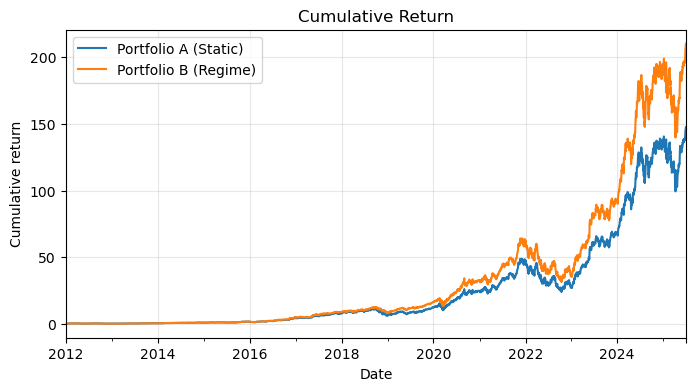

In [5]:
# Plot Portfolio A vs Portfolio B

import pandas as pd
import matplotlib.pyplot as plt

# pull series safely
sA = pd.Series(out["series"].get("PartA_daily", pd.Series(dtype=float))).sort_index()
sB = pd.Series(out["series"].get("PartB_daily", pd.Series(dtype=float))).sort_index()

if sA.empty or sB.empty:
    raise ValueError("Missing series in `out['series']`. Expected 'PartA_daily' and 'PartB_daily'.")

# cumulative returns
cumA = (1 + sA).cumprod() - 1
cumB = (1 + sB).cumprod() - 1

# --- cumulative on one chart ---
fig, ax = plt.subplots(figsize=(8, 4))
cumA.plot(ax=ax, label="Portfolio A (Static)")
cumB.plot(ax=ax, label="Portfolio B (Regime)")
ax.set_title("Cumulative Return")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative return")
ax.grid(True, alpha=0.3)
ax.legend()